In [1]:
library("rstan")
library(rethinking)
library(ggplot2) 
library(gtools)
library(brms)

Loading required package: ggplot2
Loading required package: StanHeaders
rstan (Version 2.17.3, GitRev: 2e1f913d3ca3)
For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)
Loading required package: parallel
rethinking (Version 1.59)

Attaching package: ‘gtools’

The following object is masked from ‘package:rethinking’:

    logit

Loading required package: Rcpp
Loading 'brms' package (version 2.1.0). Useful instructions
can be found by typing help('brms'). A more detailed introduction
to the package is available through vignette('brms_overview').
Run theme_set(theme_default()) to use the default bayesplot theme.

Attaching package: ‘brms’

The following objects are masked from ‘package:rethinking’:

    LOO, stancode, WAIC



In [2]:
d <- read.csv('SliderBias-PctStudy.tsv', sep='\t')

In [3]:
d$expected_rating = d$expected_rating/100
d$rating = d$rating/100
d_new <- d[d$expected_rating!=0.0 & d$expected_rating!=1.0 & d$rating!=0.0 & d$rating!=1.0, ]

In [4]:
h <- map(
    alist(
        rating ~ dnorm( mu , sigma ) ,
        mu <- a + b*expected_rating,
        a ~ dnorm( 178 , 100 ) ,
        b ~ dnorm( 0 , 100 ) ,
        sigma ~ dunif( 0 , 50 )
    ) ,
    data=d )

In [5]:
precis(h)

       Mean StdDev  5.5% 94.5%
a     -0.01      0 -0.01 -0.01
b      1.01      0  1.01  1.01
sigma  0.03      0  0.03  0.03

In [6]:
summary(h)

       Mean StdDev  5.5% 94.5%
a     -0.01      0 -0.01 -0.01
b      1.01      0  1.01  1.01
sigma  0.03      0  0.03  0.03

[ 1000 / 1000 ]
[ 1000 / 1000 ]


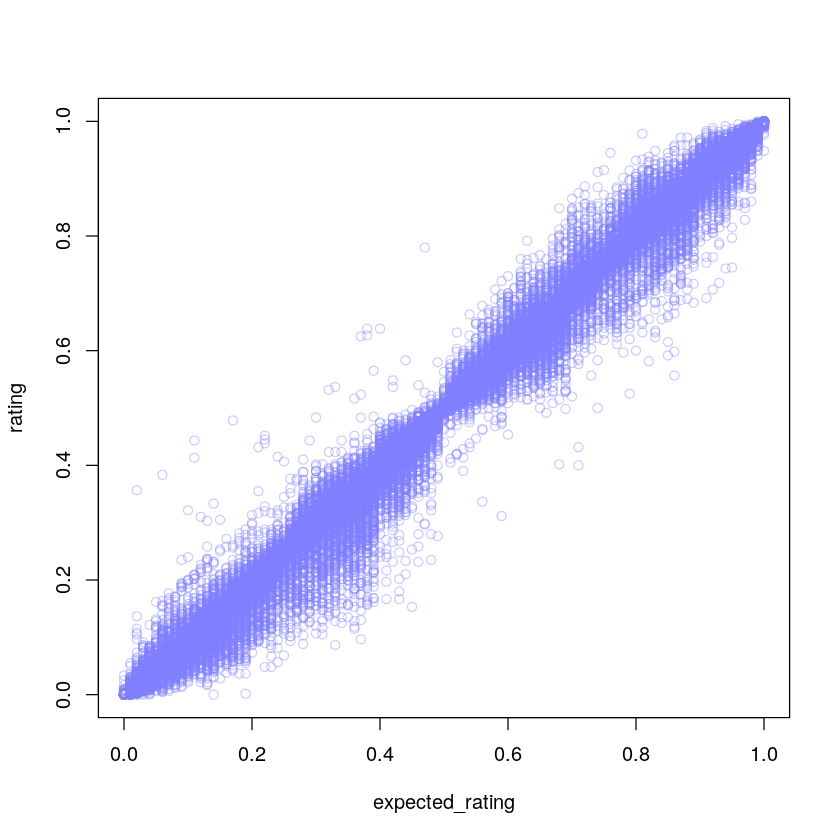

In [7]:
plot(rating ~ expected_rating, data = d,
     col = col.alpha(rangi2, 0.4) )

expected_rating.seq = seq(from=0, to=100, length.out=20) #from min value to max value of x axis, get 20 values
pred_dat = list(expected_rating=expected_rating.seq) #list is created

#run simulation for getting simulated heights
sim.rating <- sim(h, data=pred_dat)
rating.HPDI <- apply(sim.rating, 2, HPDI, prob=0.97)

#plot the lines
#since we are not sure whether it is a line or not, it is always safer to use (than abline):
mu = link (h, data=pred_dat)
# summarize the distribution of mu
mu.mean = apply(mu, 2, mean) # compute the mean of each column (average mu at each weight value)
mu.HPDI = apply(mu, 2, HPDI, prob = 0.97) #97% bounds for each weight value

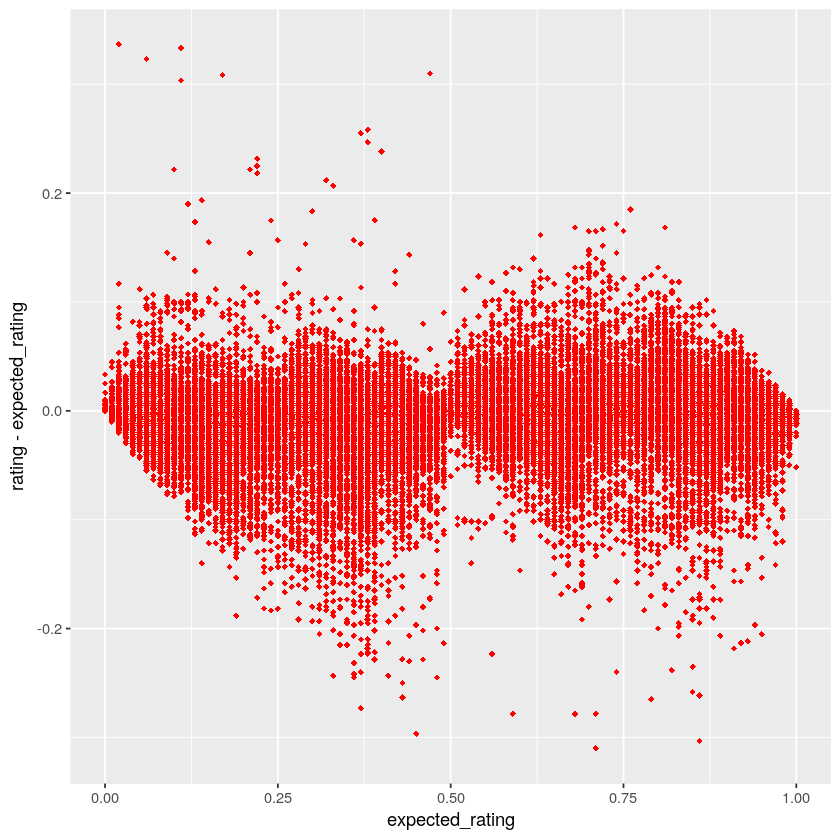

In [8]:
ggplot(d, aes(x=expected_rating, y=rating-expected_rating)) + geom_point(shape=18, color="red" )

In [9]:
h <- map2stan(
    alist(
        rating ~ dbeta((mu * exp(logv)), ((1 - mu) * exp(logv))),
        mu <- inv_logit(a + b * logit(expected_rating)),
        a ~ dnorm( 0 , 1),
        b ~ dnorm( 1 , 1),
        logv ~ dnorm( 0 , 10 )
    ),
    start=list(a=0,b=1),
    sample=FALSE,
    data=d_new)

In [10]:
cat(h$model)

data{
    int<lower=1> N;
    real rating[N];
    real expected_rating[N];
}
parameters{
    real a;
    real b;
    real logv;
}
model{
    vector[N] mu;
    logv ~ normal( 0 , 10 );
    b ~ normal( 1 , 1 );
    a ~ normal( 0 , 1 );
    for ( i in 1:N ) {
        mu[i] = inv_logit(a + b * logit(expected_rating[i]));
    }
    rating ~ beta( (mu * exp(logv)) , ((1 - mu) * exp(logv)) );
}
generated quantities{
    vector[N] mu;
    real dev;
    dev = 0;
    for ( i in 1:N ) {
        mu[i] = inv_logit(a + b * logit(expected_rating[i]));
    }
    dev = dev + (-2)*beta_lpdf( rating | (mu * exp(logv)) , ((1 - mu) * exp(logv)) );
}


In [11]:
#brm(rating ~ logit(expected_rating), data=d_new[1:20,], family=Beta)

In [15]:
d_two_columns = d[,c('rating','expected_rating')]

In [16]:
d_two_columns[1,]

rating,expected_rating
0.6466667,0.65


In [19]:
fit <- stan(file = 'vas-model.stan', data = d_two_columns, 
            iter = 1000, chains = 4)

failed to create the sampler; sampling not done


In [20]:
?stan